In [2]:
import argparse
import os
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

In [5]:
class MLP(nn.Module):
    def __init__(self, image_channels=1, hidden_size=128, hidden_layers=3):
        super().__init__()
        self.initial_conv = ConvBlock(image_channels, hidden_size, kernel_size=7, stride=2, padding=3)
        self.conv_blocks = nn.Sequential(*[ConvBlock(hidden_size, hidden_size) for _ in range(hidden_layers - 1)])
        self.upsample = nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size=4, stride=2, padding=1)  
        self.final_conv = nn.Conv2d(hidden_size, image_channels, kernel_size=3, stride=1, padding=1)

        # ajouter des linear ( MLP ) pour le label 
        
    def forward(self, x):
        x = self.initial_conv(x)
        x = self.conv_blocks(x)
        x = self.upsample(x)  # Application de l'upsample
        x = self.final_conv(x)
        return x



In [6]:
def train_bis(model, dataloader, optimizer, device, config):
    model.train()
    noise_factor = 0.5
    total_loss = 0
    for batch_idx , (data, _) in tqdm(enumerate(dataloader)):
        
        for noise_factor in np.arange(0.4, 4, 0.2):
            
            noise = torch.randn_like(data) * noise_factor 
            
            noisy_data = data + noise
            noisy_data = noisy_data.to(device)
            data = data.to(device)

            optimizer.zero_grad()

            # Le modèle essaie de débruiter l'image
            output = model(noisy_data)

            # Calculer la perte par rapport aux images originales non bruitées
            loss = F.mse_loss(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [7]:
def train_bis_bis(model, dataloader, optimizer, device, config):
    model.train()
    noise_factor = 0.5
    total_loss = 0
    for batch_idx , (data, _) in tqdm(enumerate(dataloader)):
        noisy_data= data.to(device)
        for i in range(10):
            noise = torch.randn_like(data) * 0.5
            noise = noise.to(device)   
            
            noisy_data_pred = noisy_data
            
            noisy_data = noisy_data_pred + noise
            
            noisy_data = noisy_data.to(device)

            optimizer.zero_grad()

            # Le modèle essaie de débruiter l'image
            output = model(noisy_data)

            # Calculer la perte par rapport aux images originales non bruitées
            loss = F.mse_loss(output, noisy_data_pred)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [8]:
def train_param(model, dataloader, optimizer, device, config):

    model.train()
    noise_factor = 0.5
    total_loss = 0
    for batch_idx , (data, _) in tqdm(enumerate(dataloader)):
        
        for noise_factor in np.arange(0.1, 1, 0.1):
            # noise factor = lambda 
            
            noise = torch.randn_like(data) * noise_factor 
            noisy_data = (1 - noise_factor) * data + noise
            
            noisy_data = noisy_data.to(device)
            data = data.to(device)

            optimizer.zero_grad()

            # Le modèle essaie de débruiter l'image
            output = model(noisy_data)

            # Calculer la perte par rapport aux images originales non bruitées
            loss = F.mse_loss(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [9]:

def main(config, train=train_param, path='mnist_model_param.pth'):
    losses = []
    val_losses = []
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    #dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)
    
    # train and validation split 80% - 20%
    
    train_set, val_set = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
    dataloader = DataLoader(train_set, batch_size=config.train_batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=config.train_batch_size, shuffle=False)

    model = MLP().to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    for epoch in range(config.num_epochs):
        # put data into device
        loss = train(model, dataloader, optimizer, device,config) # train à choisir 
        losses.append(loss)
        print(f"Epoch: {epoch+1}, Loss: {loss}")
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                noise_factor = np.random.uniform(0.1, 1)
                data = torch.randn_like(data) * noise_factor + (1 - noise_factor) * data
                data = data.to(device) 
                output = model(data)
                val_loss += F.mse_loss(output, data).item()
        val_loss /= len(val_loader)
        print(f"Validation loss: {val_loss}")
        
        val_losses.append(val_loss)
        
        
    plt.plot(losses)
    plt.title('Loss training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.plot(val_losses)
    plt.title('Loss validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    # Sauvegarder le modèle
    if not os.path.exists('models'):
        os.makedirs('models')
    torch.save(model.state_dict(), f"models/"+path) # Nom à changer à chaque fois 


In [61]:
class Config:
    train_batch_size = 32
    num_epochs = 15
    learning_rate = 1e-3
    num_timesteps = 50
    beta_schedule = "linear"
    eval_batch_size = 1000
    image_size =28
    
    
config = Config()
main(config)

0it [00:00, ?it/s]

7it [00:02,  2.35it/s]


KeyboardInterrupt: 

MLP(
  (initial_conv): ConvBlock(
    (conv): Conv2d(1, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (conv_blocks): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (1): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
  )
  (upsample): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (final_conv): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
torch.Size([5, 1, 28, 28])


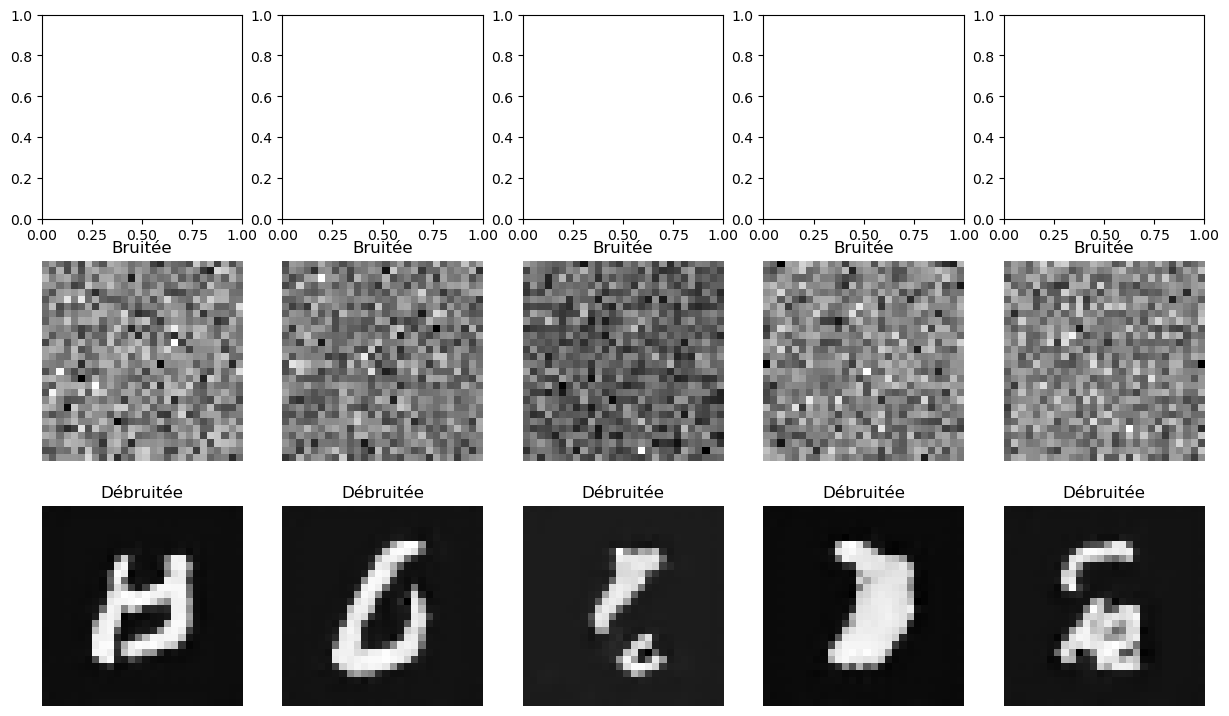

In [42]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=5, shuffle=True)


model = MLP()
model.load_state_dict(torch.load('models/mnist_model_param.pth'))

# Afficher l'architecture du modèle
print(model)

# Prendre 5 images du dataset MNIST et les bruiter

images, labels = next(iter(mnist_loader))
#noisy_images = images + 3* torch.randn_like(images)  # Ajout d'un bruit gaussien
noisy_images = 0.5*torch.randn_like(images)

denoised_images = model(noisy_images)
denoised_images = model(denoised_images)


print(denoised_images.shape)

fig, axs = plt.subplots(3, 5, figsize=(15, 9))
for i in range(5):
    """axs[0, i].imshow(images[i].squeeze().detach().numpy(), cmap='gray')
    axs[0, i].title.set_text('Original')
    axs[0, i].axis('off')"""
    
    axs[1, i].imshow(noisy_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[1, i].title.set_text('Bruitée')
    axs[1, i].axis('off')

    axs[2, i].imshow(denoised_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[2, i].title.set_text('Débruitée')
    axs[2, i].axis('off')

plt.show()



MLP(
  (initial_conv): ConvBlock(
    (conv): Conv2d(1, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (conv_blocks): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (1): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
  )
  (upsample): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (final_conv): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
torch.Size([5, 1, 28, 28])


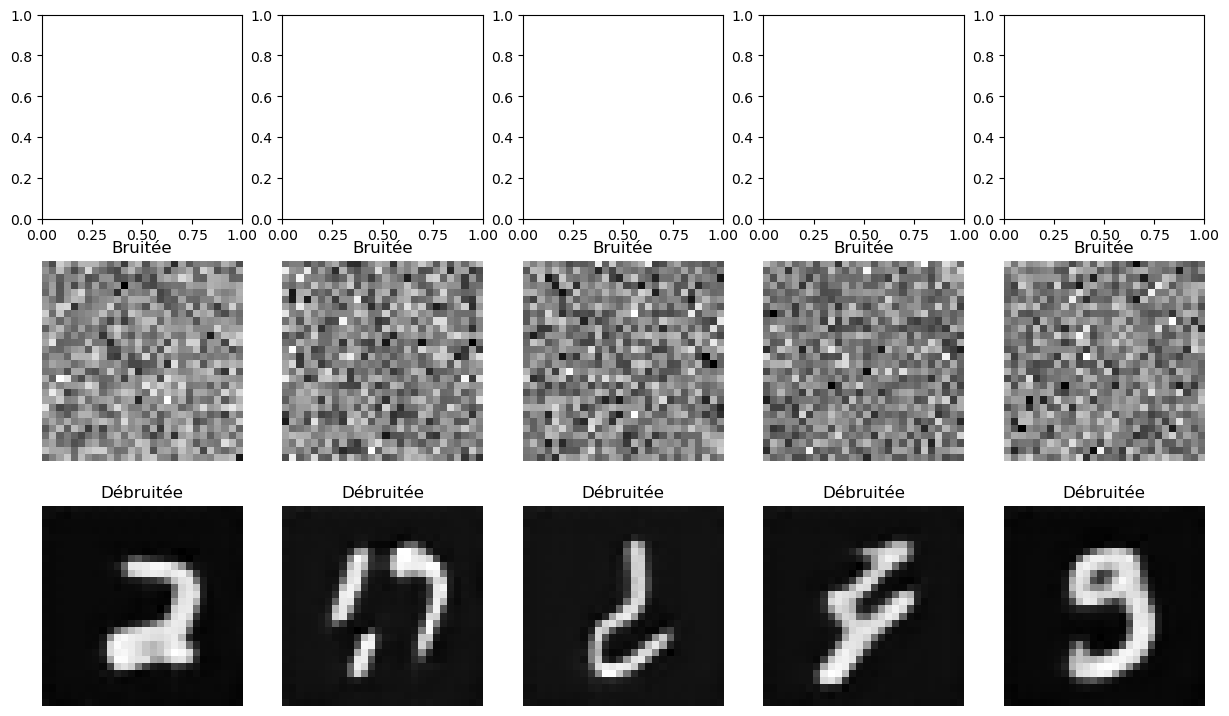

In [36]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=5, shuffle=True)


model = MLP()
model.load_state_dict(torch.load('models/mnist_model_train_bis_0.2_15.pth'))

# Afficher l'architecture du modèle
print(model)

# Prendre 5 images du dataset MNIST et les bruiter
images, labels = next(iter(mnist_loader))
#noisy_images = images + 3* torch.randn_like(images)  # Ajout d'un bruit gaussien
noisy_images = 0.5*torch.randn_like(images)

denoised_images = model(noisy_images)
denoised_images = model(denoised_images)
denoised_images = model(denoised_images)
denoised_images = model(denoised_images)
denoised_images = model(denoised_images)

print(denoised_images.shape)

fig, axs = plt.subplots(3, 5, figsize=(15, 9))
for i in range(5):
    """axs[0, i].imshow(images[i].squeeze().detach().numpy(), cmap='gray')
    axs[0, i].title.set_text('Original')
    axs[0, i].axis('off')"""
    
    axs[1, i].imshow(noisy_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[1, i].title.set_text('Bruitée')
    axs[1, i].axis('off')

    axs[2, i].imshow(denoised_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[2, i].title.set_text('Débruitée')
    axs[2, i].axis('off')

plt.show()



# Ablation study 

## Learning rate 

### train_bis

In [15]:

class Config:
    train_batch_size = 32
    num_epochs = 25
    learning_rate = 1e-3
    image_size =28
    
config = Config()
main(config, train=train_bis, path='mnist_model_train_bis_25_3.pth')


1875it [01:22, 22.76it/s]


Epoch: 1, Loss: 2.037893049668272


1875it [01:20, 23.20it/s]


Epoch: 2, Loss: 1.9632738827059666


1875it [01:21, 23.02it/s]


Epoch: 3, Loss: 1.9470737562328577


1875it [01:21, 23.03it/s]


Epoch: 4, Loss: 1.9392965201025207


1875it [01:21, 23.02it/s]


Epoch: 5, Loss: 1.9335265095124643


1875it [01:21, 23.10it/s]


Epoch: 6, Loss: 1.9298011211728057


1875it [01:21, 23.08it/s]


Epoch: 7, Loss: 1.926623645579815


1875it [01:21, 23.12it/s]


Epoch: 8, Loss: 1.9234682791690032


1875it [01:21, 23.07it/s]


Epoch: 9, Loss: 1.922144642514487


1875it [01:20, 23.22it/s]


Epoch: 10, Loss: 1.9198707198267182


1875it [01:20, 23.27it/s]


Epoch: 11, Loss: 1.9186069510196646


1875it [01:21, 23.14it/s]


Epoch: 12, Loss: 1.9160510357439517


1875it [01:21, 23.07it/s]


Epoch: 13, Loss: 1.915275900121033


1875it [01:20, 23.22it/s]


Epoch: 14, Loss: 1.91336608064274


1875it [01:21, 23.13it/s]

Epoch: 15, Loss: 1.9141050115004181


1875it [01:20, 23.22it/s]


Epoch: 1, Loss: 2.1065060683056713


1875it [01:20, 23.35it/s]


Epoch: 2, Loss: 2.0009999045868714


1875it [01:20, 23.32it/s]


Epoch: 3, Loss: 1.9722585749775172


1875it [01:20, 23.34it/s]


Epoch: 4, Loss: 1.960452297069629


1875it [01:20, 23.32it/s]


Epoch: 5, Loss: 1.9508417299434542


1875it [01:20, 23.32it/s]


Epoch: 6, Loss: 1.9429725059246024


1875it [01:20, 23.33it/s]


Epoch: 7, Loss: 1.9377528429572781


1875it [01:20, 23.32it/s]


Epoch: 8, Loss: 1.9321006382649144


1875it [01:20, 23.37it/s]


Epoch: 9, Loss: 1.9290223177358508


1875it [01:21, 23.15it/s]


Epoch: 10, Loss: 1.9252441564872862


1875it [01:21, 23.01it/s]


Epoch: 11, Loss: 1.922694083295266


1875it [01:26, 21.58it/s]


Epoch: 12, Loss: 1.9210548400456706


1875it [01:25, 22.03it/s]


Epoch: 13, Loss: 1.9189264937077959


1875it [01:21, 22.93it/s]


Epoch: 14, Loss: 1.9162477906003594


1875it [01:21, 23.14it/s]


Epoch: 15, Loss: 1.915443868982792


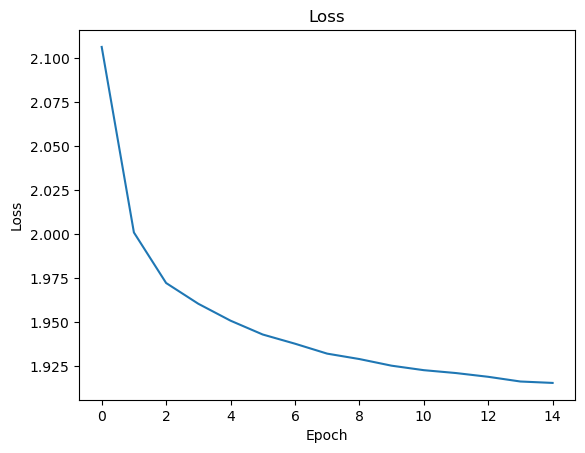

In [17]:
class Config:
    train_batch_size = 32
    num_epochs = 25
    learning_rate = 1e-4
    image_size =28
    
config = Config()
main(config, train=train_bis, path='mnist_model_train_bis_25_4.pth')

0it [00:00, ?it/s]

1500it [01:04, 23.19it/s]


Epoch: 1, Loss: 2.347885167659571
Validation loss: 0.973327359755834


1500it [01:04, 23.18it/s]


Epoch: 2, Loss: 2.1493692463450134
Validation loss: 1.056002981185913


1500it [01:04, 23.14it/s]


Epoch: 3, Loss: 2.1079780594638238
Validation loss: 1.0223895707130433


1500it [01:04, 23.12it/s]


Epoch: 4, Loss: 2.0814088635059695
Validation loss: 0.9924155263900757


1500it [01:04, 23.30it/s]


Epoch: 5, Loss: 2.062721740822618
Validation loss: 0.9715832155545553


1500it [01:04, 23.17it/s]


Epoch: 6, Loss: 2.045848810189714
Validation loss: 1.0021034118334453


1500it [01:03, 23.61it/s]


Epoch: 7, Loss: 2.034543740886574
Validation loss: 0.9825221223036448


1500it [01:03, 23.68it/s]


Epoch: 8, Loss: 2.024424480487903
Validation loss: 0.9611125654379526


1500it [01:03, 23.65it/s]


Epoch: 9, Loss: 2.01560021267583
Validation loss: 1.0178121367295583


1500it [01:03, 23.66it/s]


Epoch: 10, Loss: 2.0075073814888795
Validation loss: 0.9771351576646169


1500it [01:03, 23.65it/s]


Epoch: 11, Loss: 2.002914386625091
Validation loss: 0.9542789920965831


1500it [01:03, 23.64it/s]


Epoch: 12, Loss: 1.9979053229099761
Validation loss: 0.9701146269639334


1500it [01:03, 23.51it/s]


Epoch: 13, Loss: 1.9919482273813338
Validation loss: 1.0263158962726593


1500it [01:03, 23.57it/s]


Epoch: 14, Loss: 1.9878651002477854
Validation loss: 0.9500118939876556


1500it [01:03, 23.69it/s]


Epoch: 15, Loss: 1.9835508572813123
Validation loss: 0.9228117582798004


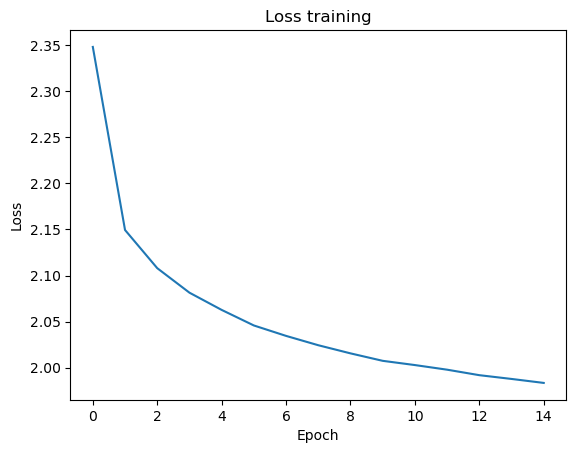

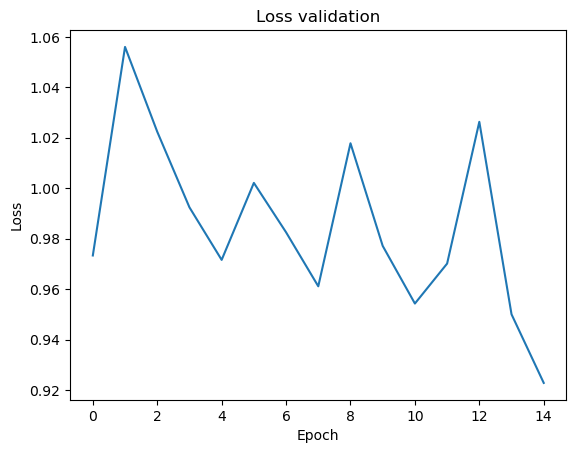

In [28]:
class Config:
    train_batch_size = 32
    num_epochs = 25
    learning_rate = 1e-5
    image_size =28
    
config = Config()
main(config, train=train_bis, path='mnist_model_train_bis_25_5.pth')

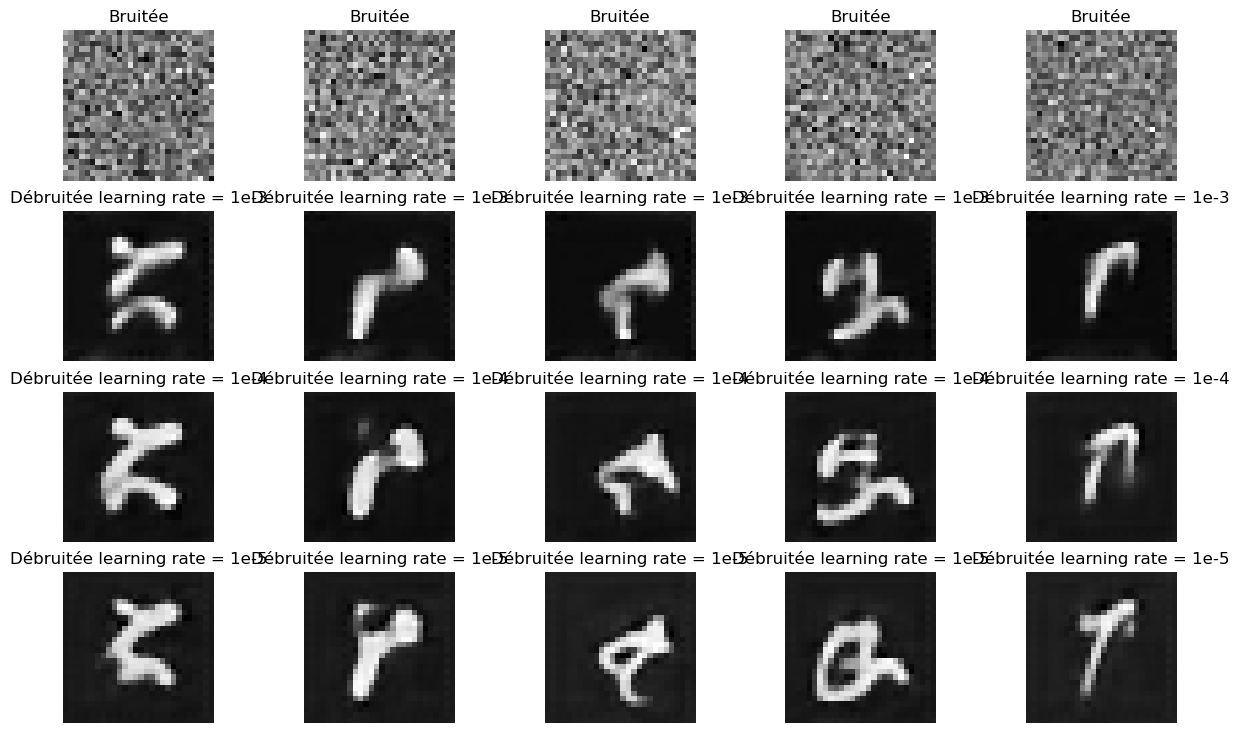

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=5, shuffle=True)

model1 = MLP()
model1.load_state_dict(torch.load('models/mnist_model_train_bis_0.5_15_3.pth'))

model2 = MLP()
model2.load_state_dict(torch.load('models/mnist_model_train_bis_0.5_15_4.pth'))

model3 = MLP()
model3.load_state_dict(torch.load('models/mnist_model_train_bis_0.5_15_5.pth'))

# Prendre 5 images du dataset MNIST et les bruiter
images, labels = next(iter(mnist_loader))
#noisy_images = images + 3* torch.randn_like(images)  # Ajout d'un bruit gaussien
noisy_images = 0.5*torch.randn_like(images)

denoised_images1 = model1(noisy_images)
denoised_images1 = model1(denoised_images1)
denoised_images1 = model1(denoised_images1)
denoised_images1 = model1(denoised_images1)

denoised_images2 = model2(noisy_images)
denoised_images2 = model2(denoised_images2)
denoised_images2 = model2(denoised_images2)
denoised_images2 = model2(denoised_images2)

denoised_images3 = model3(noisy_images)
denoised_images3 = model3(denoised_images3)
denoised_images3 = model3(denoised_images3)
denoised_images3 = model3(denoised_images3)

fig, axs = plt.subplots(4, 5, figsize=(15, 9))
for i in range(5):
    axs[0, i].imshow(noisy_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[0, i].title.set_text('Bruitée')
    axs[0, i].axis('off')

    axs[1, i].imshow(denoised_images1[i].squeeze().detach().numpy(), cmap='gray')
    axs[1, i].title.set_text('Learning rate = 1e-3')
    axs[1, i].axis('off')
    
    axs[2, i].imshow(denoised_images2[i].squeeze().detach().numpy(), cmap='gray')
    axs[2, i].title.set_text('Learning rate = 1e-4')
    axs[2, i].axis('off')
    
    axs[3, i].imshow(denoised_images3[i].squeeze().detach().numpy(), cmap='gray')
    axs[3, i].title.set_text('Learning rate = 1e-5')
    axs[3, i].axis('off')

plt.show()


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=5, shuffle=True)

model1 = MLP()
model1.load_state_dict(torch.load('models/mnist_model_train_bis_0.5_25_3.pth'))

model2 = MLP()
model2.load_state_dict(torch.load('models/mnist_model_train_bis_0.5_25_4.pth'))

model3 = MLP()
model3.load_state_dict(torch.load('models/mnist_model_train_bis_0.5_25_5.pth'))

# Prendre 5 images du dataset MNIST et les bruiter
images, labels = next(iter(mnist_loader))
#noisy_images = images + 3* torch.randn_like(images)  # Ajout d'un bruit gaussien
noisy_images = 0.5*torch.randn_like(images)

denoised_images1 = model1(noisy_images)
denoised_images1 = model1(denoised_images1)
denoised_images1 = model1(denoised_images1)
denoised_images1 = model1(denoised_images1)

denoised_images2 = model2(noisy_images)
denoised_images2 = model2(denoised_images2)
denoised_images2 = model2(denoised_images2)
denoised_images2 = model2(denoised_images2)

denoised_images3 = model3(noisy_images)
denoised_images3 = model3(denoised_images3)
denoised_images3 = model3(denoised_images3)
denoised_images3 = model3(denoised_images3)

fig, axs = plt.subplots(4, 5, figsize=(15, 9))
for i in range(5):
    axs[0, i].imshow(noisy_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[0, i].title.set_text('Bruitée')
    axs[0, i].axis('off')

    axs[1, i].imshow(denoised_images1[i].squeeze().detach().numpy(), cmap='gray')
    axs[1, i].title.set_text('Learning rate = 1e-3')
    axs[1, i].axis('off')
    
    axs[2, i].imshow(denoised_images2[i].squeeze().detach().numpy(), cmap='gray')
    axs[2, i].title.set_text('Learning rate = 1e-4')
    axs[2, i].axis('off')
    
    axs[3, i].imshow(denoised_images3[i].squeeze().detach().numpy(), cmap='gray')
    axs[3, i].title.set_text('Learning rate = 1e-5')
    axs[3, i].axis('off')

plt.show()


### train_param

1500it [00:34, 43.33it/s]


Epoch: 1, Loss: 0.8301925603315855
Validation loss: 0.5426445535520713


1500it [00:34, 43.08it/s]


Epoch: 2, Loss: 0.7701741129580575
Validation loss: 0.5230827080011368


1500it [00:34, 43.03it/s]


Epoch: 3, Loss: 0.759090773719363
Validation loss: 0.44159835418562093


1500it [00:34, 43.20it/s]


Epoch: 4, Loss: 0.75407765553069
Validation loss: 0.5051242674887181


1500it [00:34, 43.19it/s]


Epoch: 5, Loss: 0.7501586960437707
Validation loss: 0.5214276435673237


1500it [00:34, 43.22it/s]


Epoch: 6, Loss: 0.7483526960154996
Validation loss: 0.4903949592808882


1500it [00:35, 42.12it/s]


Epoch: 7, Loss: 0.7455390425501391
Validation loss: 0.5214490659932296


1500it [00:35, 41.78it/s]


Epoch: 8, Loss: 0.7447511772873501
Validation loss: 0.5158858855267365


1500it [00:34, 42.94it/s]


Epoch: 9, Loss: 0.7426108640767634
Validation loss: 0.5273871465027332


1500it [00:34, 43.18it/s]


Epoch: 10, Loss: 0.7414835828724318
Validation loss: 0.5178008874754111


1500it [00:34, 43.09it/s]


Epoch: 11, Loss: 0.7411244604559615
Validation loss: 0.5251470280786356


1500it [00:34, 43.01it/s]


Epoch: 12, Loss: 0.740874931495171
Validation loss: 0.5440358069241047


1500it [00:34, 43.00it/s]


Epoch: 13, Loss: 0.7394880506141732
Validation loss: 0.5163602179288864


1500it [00:34, 43.02it/s]


Epoch: 14, Loss: 0.738765254452359
Validation loss: 0.521864880134662


1500it [00:34, 42.92it/s]


Epoch: 15, Loss: 0.7374465695445737
Validation loss: 0.5306281812588374


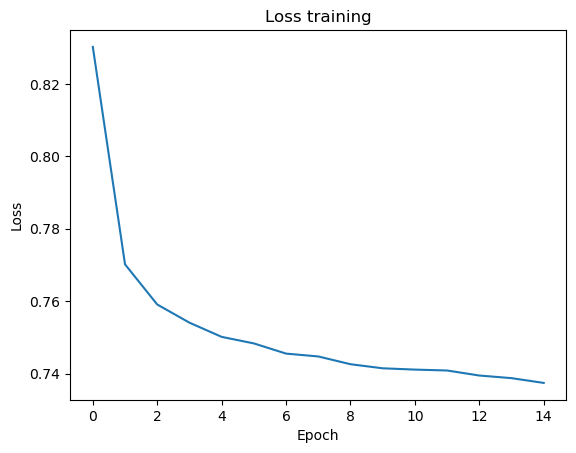

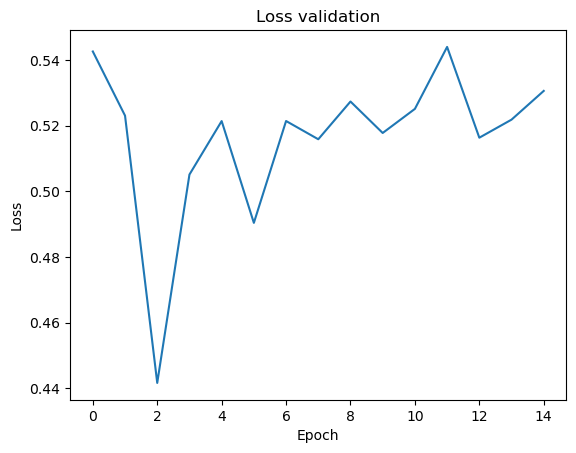

In [29]:
class Config:
    train_batch_size = 32
    num_epochs = 25
    learning_rate = 1e-3
    image_size =28
    
config = Config()
main(config, train=train_param, path='mnist_model_train_param_0.1_25_3.pth')

1500it [00:35, 42.36it/s]


Epoch: 1, Loss: 0.8525346932026248
Validation loss: 0.47634327720602354


1500it [00:34, 43.15it/s]


Epoch: 2, Loss: 0.7883228208792086
Validation loss: 0.4760227298438549


1500it [00:34, 43.20it/s]


Epoch: 3, Loss: 0.7743148318254389
Validation loss: 0.5039520928661029


1500it [00:34, 43.13it/s]


Epoch: 4, Loss: 0.7668043795128663
Validation loss: 0.4719610567390919


1500it [00:34, 43.17it/s]


Epoch: 5, Loss: 0.7612671122063572
Validation loss: 0.4536917680899302


1500it [00:34, 43.18it/s]


Epoch: 6, Loss: 0.7580639563115934
Validation loss: 0.4850887031406164


1500it [00:34, 43.17it/s]


Epoch: 7, Loss: 0.7540450346786529
Validation loss: 0.4993459141403437


1500it [00:34, 43.18it/s]


Epoch: 8, Loss: 0.752264515652787
Validation loss: 0.45957934113343557


1500it [00:34, 43.15it/s]


Epoch: 9, Loss: 0.7498508398973693
Validation loss: 0.48149986388285954


1500it [00:34, 43.18it/s]


Epoch: 10, Loss: 0.7477102708752887
Validation loss: 0.498257107069095


1500it [00:34, 43.20it/s]


Epoch: 11, Loss: 0.7467133485417192
Validation loss: 0.47261223221818605


1500it [00:34, 43.20it/s]


Epoch: 12, Loss: 0.7454935154560953
Validation loss: 0.4889955421189467


1500it [00:34, 43.19it/s]


Epoch: 13, Loss: 0.7441532670206701
Validation loss: 0.4980956775943438


1500it [00:34, 43.19it/s]


Epoch: 14, Loss: 0.7428452037912794
Validation loss: 0.46792438807090125


1500it [00:34, 43.18it/s]


Epoch: 15, Loss: 0.742497149636348
Validation loss: 0.47482602022091547


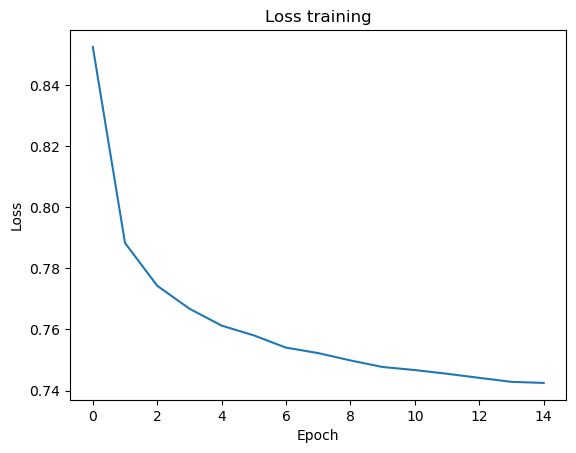

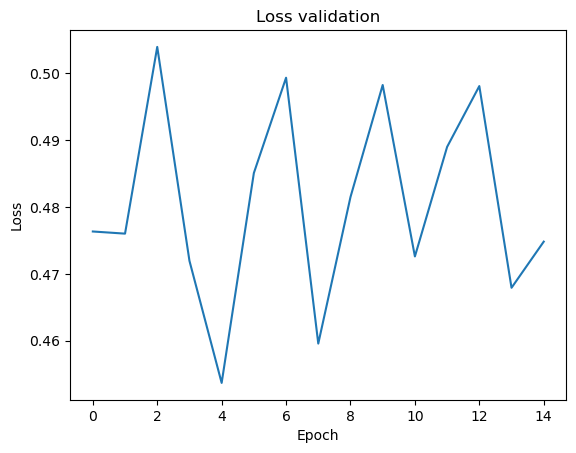

In [37]:
class Config:
    train_batch_size = 32
    num_epochs = 25
    learning_rate = 1e-4
    image_size =28
    
config = Config()
main(config, train=train_param, path='mnist_model_train_param_0.1_25_4.pth')

1500it [00:34, 43.86it/s]


Epoch: 1, Loss: 0.9950660575193664
Validation loss: 0.5042057600021362


1500it [00:34, 43.44it/s]


Epoch: 2, Loss: 0.8593279485488311
Validation loss: 0.4766061956683795


1500it [00:34, 43.06it/s]


Epoch: 3, Loss: 0.8346138270922626
Validation loss: 0.5013204496403535


1500it [00:34, 43.12it/s]


Epoch: 4, Loss: 0.8207049900259201
Validation loss: 0.4988910823067029


1500it [00:34, 43.09it/s]


Epoch: 5, Loss: 0.8116243907936538
Validation loss: 0.5017533290286859


1500it [00:34, 43.10it/s]


Epoch: 6, Loss: 0.8049018974319722
Validation loss: 0.49526722649733224


1500it [00:34, 43.10it/s]


Epoch: 7, Loss: 0.7987767679995547
Validation loss: 0.47012035990754764


1500it [00:34, 43.05it/s]


Epoch: 8, Loss: 0.7942292680980948
Validation loss: 0.4719113443394502


1500it [00:34, 42.98it/s]


Epoch: 9, Loss: 0.7892806187886745
Validation loss: 0.5090566076934337


1500it [00:34, 42.97it/s]


Epoch: 10, Loss: 0.7863162675523199
Validation loss: 0.4817642731765906


1500it [00:35, 42.75it/s]


Epoch: 11, Loss: 0.783178474140043
Validation loss: 0.5029886215527852


1500it [00:35, 42.04it/s]


Epoch: 12, Loss: 0.7804877245224392
Validation loss: 0.4829422638018926


1500it [00:35, 42.15it/s]


Epoch: 13, Loss: 0.7776350277704187
Validation loss: 0.4562959945400556


1500it [00:35, 42.16it/s]


Epoch: 14, Loss: 0.7752815061473909
Validation loss: 0.4787088231245677


1500it [00:35, 42.14it/s]


Epoch: 15, Loss: 0.7739450033735484
Validation loss: 0.49664455046256384


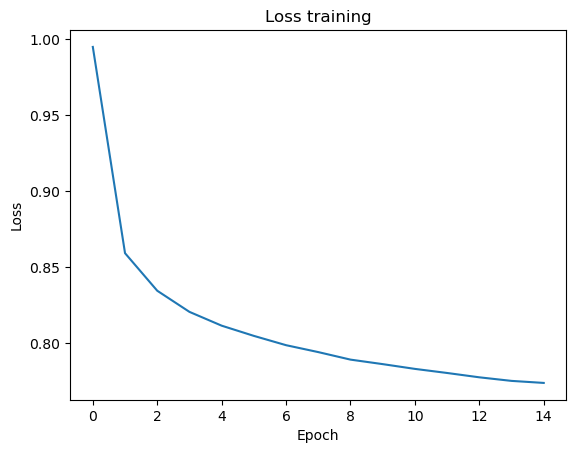

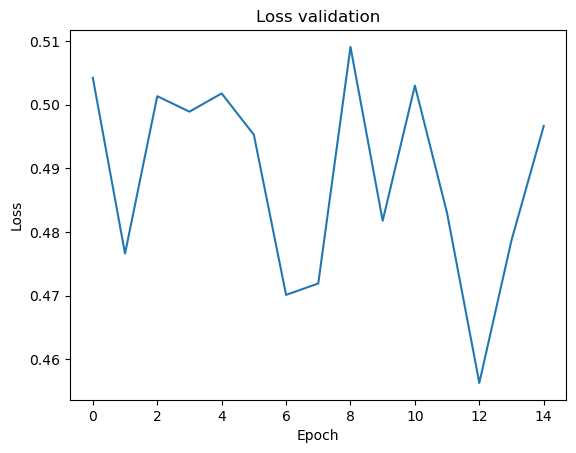

In [38]:
class Config:
    train_batch_size = 32
    num_epochs = 25
    learning_rate = 1e-5
    image_size =28
    
config = Config()
main(config, train=train_param, path='mnist_model_train_param_0.1_25_5.pth')

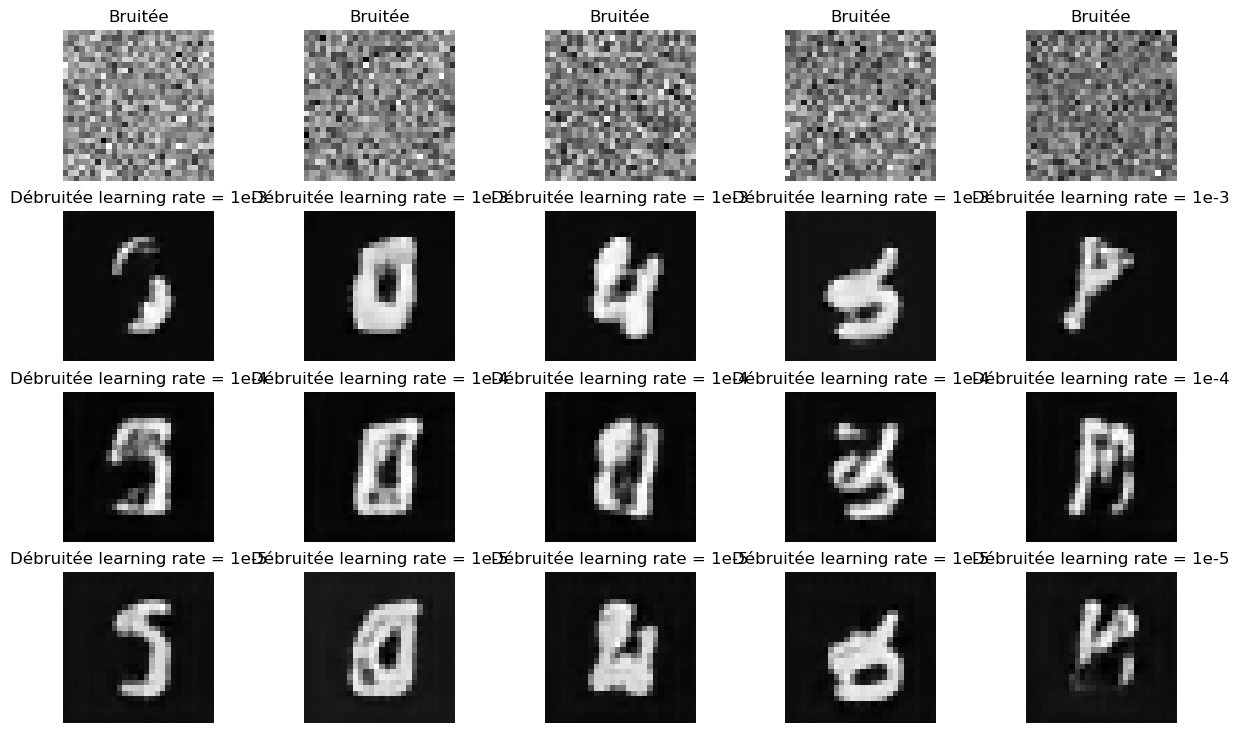

In [38]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=5, shuffle=True)

# we test the parametric model
model1 = MLP()
model1.load_state_dict(torch.load('models/mnist_model_train_param_0.1_15_3.pth'))

model2 = MLP()
model2.load_state_dict(torch.load('models/mnist_model_train_param_0.1_15_4.pth'))

model3 = MLP()
model3.load_state_dict(torch.load('models/mnist_model_train_param_0.1_15_5.pth'))

# Prendre 5 images du dataset MNIST et les bruiter
images, labels = next(iter(mnist_loader))
#noisy_images = images + 3* torch.randn_like(images)  # Ajout d'un bruit gaussien
noisy_images = 0.7*torch.randn_like(images)

denoised_images1 = model1(noisy_images)
denoised_images1 = model1(denoised_images1)
denoised_images1 = model1(denoised_images1)
denoised_images1 = model1(denoised_images1)
denoised_images1 = model1(denoised_images1)

denoised_images2 = model2(noisy_images)
denoised_images2 = model2(denoised_images2)
denoised_images2 = model2(denoised_images2) 
denoised_images2 = model2(denoised_images2)
denoised_images2 = model2(denoised_images2)


denoised_images3 = model3(noisy_images)
denoised_images3 = model3(denoised_images3)
denoised_images3 = model3(denoised_images3)
denoised_images3 = model3(denoised_images3)
denoised_images3 = model3(denoised_images3)


fig, axs = plt.subplots(4, 5, figsize=(15, 9))

for i in range(5):
    axs[0, i].imshow(noisy_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[0, i].title.set_text('Bruitée')
    axs[0, i].axis('off')

    axs[1, i].imshow(denoised_images1[i].squeeze().detach().numpy(), cmap='gray')
    axs[1, i].title.set_text('Débruitée learning rate = 1e-3')
    axs[1, i].axis('off')
    
    axs[2, i].imshow(denoised_images2[i].squeeze().detach().numpy(), cmap='gray')
    axs[2, i].title.set_text('Débruitée learning rate = 1e-4')
    axs[2, i].axis('off')
    
    axs[3, i].imshow(denoised_images3[i].squeeze().detach().numpy(), cmap='gray')
    axs[3, i].title.set_text('Débruitée learning rate = 1e-5')
    axs[3, i].axis('off')

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=5, shuffle=True)

# we test the parametric model
model1 = MLP()
model1.load_state_dict(torch.load('models/mnist_model_train_param_0.1_25_3.pth'))

model2 = MLP()
model2.load_state_dict(torch.load('models/mnist_model_train_param_0.1_25_4.pth'))

model3 = MLP()
model3.load_state_dict(torch.load('models/mnist_model_train_param_0.1_25_5.pth'))

# Prendre 5 images du dataset MNIST et les bruiter
images, labels = next(iter(mnist_loader))
#noisy_images = images + 3* torch.randn_like(images)  # Ajout d'un bruit gaussien
noisy_images = 0.7*torch.randn_like(images)

denoised_images1 = model1(noisy_images)
denoised_images1 = model1(denoised_images1)
denoised_images1 = model1(denoised_images1)
denoised_images1 = model1(denoised_images1)
denoised_images1 = model1(denoised_images1)

denoised_images2 = model2(noisy_images)
denoised_images2 = model2(denoised_images2)
denoised_images2 = model2(denoised_images2) 
denoised_images2 = model2(denoised_images2)
denoised_images2 = model2(denoised_images2)


denoised_images3 = model3(noisy_images)
denoised_images3 = model3(denoised_images3)
denoised_images3 = model3(denoised_images3)
denoised_images3 = model3(denoised_images3)
denoised_images3 = model3(denoised_images3)


fig, axs = plt.subplots(4, 5, figsize=(15, 9))

for i in range(5):
    axs[0, i].imshow(noisy_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[0, i].title.set_text('Bruitée')
    axs[0, i].axis('off')

    axs[1, i].imshow(denoised_images1[i].squeeze().detach().numpy(), cmap='gray')
    axs[1, i].title.set_text('Débruitée learning rate = 1e-3')
    axs[1, i].axis('off')
    
    axs[2, i].imshow(denoised_images2[i].squeeze().detach().numpy(), cmap='gray')
    axs[2, i].title.set_text('Débruitée learning rate = 1e-4')
    axs[2, i].axis('off')
    
    axs[3, i].imshow(denoised_images3[i].squeeze().detach().numpy(), cmap='gray')
    axs[3, i].title.set_text('Débruitée learning rate = 1e-5')
    axs[3, i].axis('off')

### train_bis_bis

0it [00:00, ?it/s]

1500it [00:40, 36.69it/s]


Epoch: 1, Loss: 1.9891845565512776
Validation loss: 0.05091594764590263


1500it [00:40, 37.41it/s]


Epoch: 2, Loss: 1.877654370645682
Validation loss: 0.04914159647996227


1500it [00:40, 37.49it/s]


Epoch: 3, Loss: 1.8504424539382258
Validation loss: 0.048564037217448154


1500it [00:39, 37.60it/s]


Epoch: 4, Loss: 1.83913117031008
Validation loss: 0.051138475829114516


1500it [00:39, 37.51it/s]


Epoch: 5, Loss: 1.8334951629135758
Validation loss: 0.05480100913718343


1500it [00:40, 36.92it/s]


Epoch: 6, Loss: 1.830583690142259
Validation loss: 0.059527309748033684


1500it [00:40, 36.85it/s]


Epoch: 7, Loss: 1.8307751232658824
Validation loss: 0.04870755760868391


1500it [00:40, 36.86it/s]


Epoch: 8, Loss: 1.832069505792732
Validation loss: 0.060051738880574704


1500it [00:40, 37.07it/s]


Epoch: 9, Loss: 1.8309764247989904
Validation loss: 0.05434424736599128


1500it [00:40, 36.99it/s]


Epoch: 10, Loss: 1.8296468752026558
Validation loss: 0.0554849605858326


1500it [00:40, 37.00it/s]


Epoch: 11, Loss: 1.8278364157968512
Validation loss: 0.054616711676120755


1500it [00:40, 37.43it/s]


Epoch: 12, Loss: 1.8262611453297237
Validation loss: 0.06607208298146725


1500it [00:40, 37.44it/s]


Epoch: 13, Loss: 1.826689507789289
Validation loss: 0.06423255713284015


1500it [00:40, 37.45it/s]


Epoch: 14, Loss: 1.8252484994238862
Validation loss: 0.047503307327628135


1500it [00:40, 37.44it/s]


Epoch: 15, Loss: 1.8242378335936615
Validation loss: 0.056765337377786634


1500it [00:39, 37.53it/s]


Epoch: 16, Loss: 1.8244331721620013
Validation loss: 0.05307989311094086


1500it [00:39, 37.55it/s]


Epoch: 17, Loss: 1.823990464831392
Validation loss: 0.05554645672440529


1500it [00:39, 37.56it/s]


Epoch: 18, Loss: 1.8235144084300845
Validation loss: 0.05400838140646617


1500it [00:39, 37.52it/s]


Epoch: 19, Loss: 1.822145200011631
Validation loss: 0.061399370282888416


1500it [00:40, 37.48it/s]


Epoch: 20, Loss: 1.8213628199553737
Validation loss: 0.05794212965418895


1500it [00:39, 37.50it/s]


Epoch: 21, Loss: 1.8214240297886233
Validation loss: 0.04964763676002622


1500it [00:39, 37.50it/s]


Epoch: 22, Loss: 1.8212816172676782
Validation loss: 0.05732101351767779


1500it [00:40, 37.48it/s]


Epoch: 23, Loss: 1.8205436898904541
Validation loss: 0.0597039086210231


1500it [00:40, 36.64it/s]


Epoch: 24, Loss: 1.820717691651235
Validation loss: 0.05247870109478633


1500it [00:40, 37.16it/s]


Epoch: 25, Loss: 1.8200139644710969
Validation loss: 0.059096266871939106


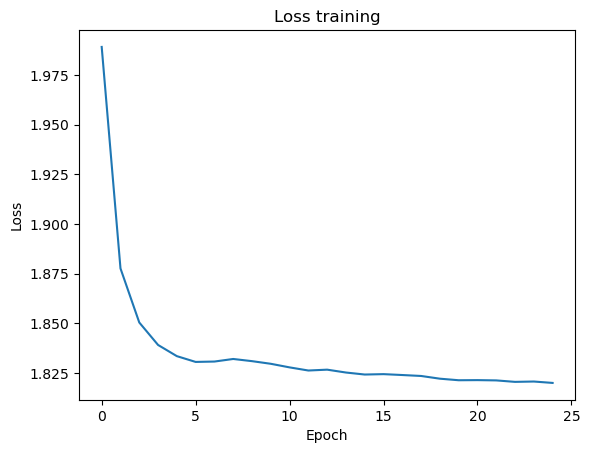

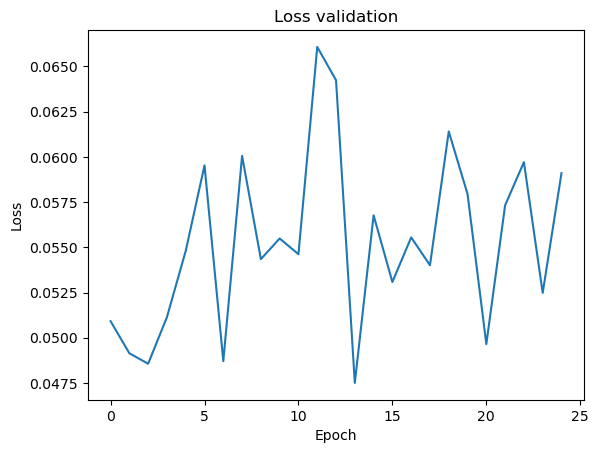

In [72]:
class Config:
    train_batch_size = 32
    num_epochs = 25
    learning_rate = 1e-3
    image_size =28
    
config = Config()
main(config, train=train_bis_bis, path='mnist_model_train_bis_bis_15_3.pth')

In [73]:
class Config:
    train_batch_size = 32
    num_epochs = 25
    learning_rate = 1e-4
    image_size =28
    
config = Config()
main(config, train=train_bis_bis, path='mnist_model_train_bis_bis_25_4.pth')

0it [00:00, ?it/s]

1488it [00:40, 36.97it/s]

In [ ]:
class Config:
    train_batch_size = 32
    num_epochs = 25
    learning_rate = 1e-5
    image_size =28
    
config = Config()
main(config, train=train_bis_bis, path='mnist_model_train_bis_bis_25_5.pth')

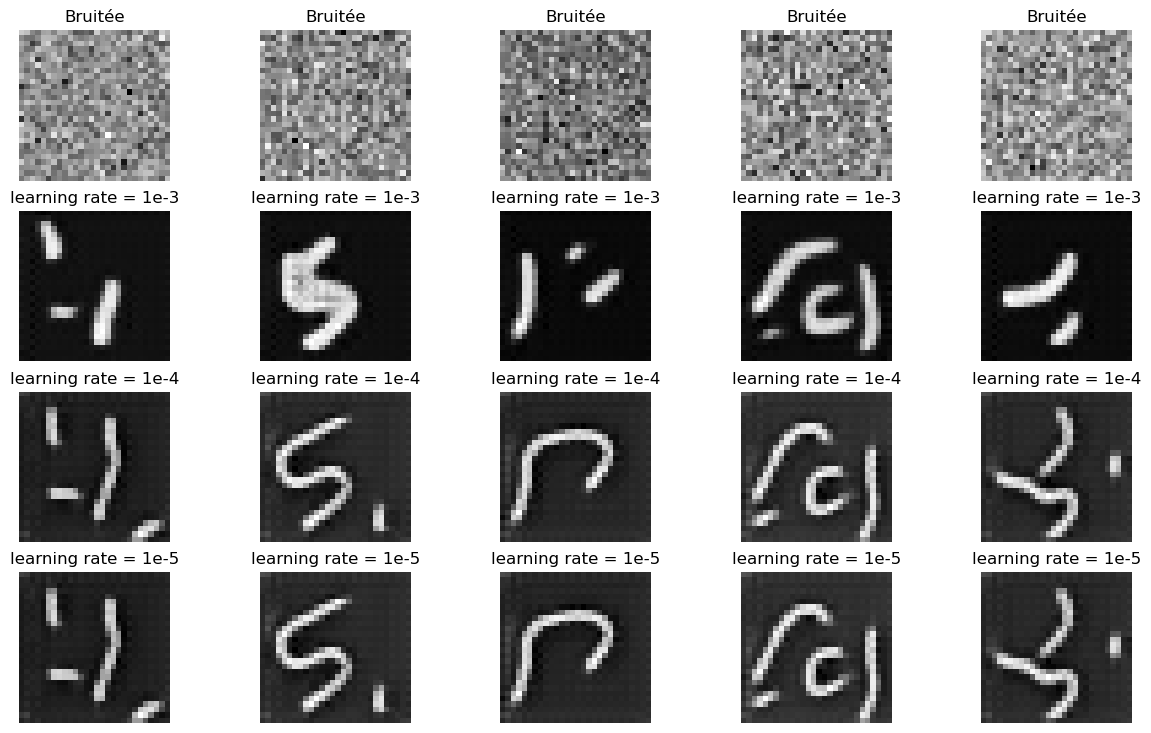

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=5, shuffle=True)

# we test the parametric model
model1 = MLP()
model1.load_state_dict(torch.load('models/mnist_model_train_bis_bis_25_3.pth'))

model2 = MLP()
model2.load_state_dict(torch.load('models/mnist_model_train_bis_bis_25_4.pth'))

model3 = MLP()
model3.load_state_dict(torch.load('models/mnist_model_train_bis_bis_25_4.pth'))

# Prendre 5 images du dataset MNIST et les bruiter
images, labels = next(iter(mnist_loader))
#noisy_images = images + 3* torch.randn_like(images)  # Ajout d'un bruit gaussien
noisy_images = 0.5*torch.randn_like(images)

denoised_images1 = model1(noisy_images)
denoised_images2 = model2(noisy_images)
denoised_images3 = model3(noisy_images)

for i in range (20):
    denoised_images1 = model1(denoised_images1)
    denoised_images2 = model2(denoised_images2)
    denoised_images3 = model3(denoised_images3)


fig, axs = plt.subplots(4, 5, figsize=(15, 9))

for i in range(5):
    axs[0, i].imshow(noisy_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[0, i].title.set_text('Bruitée')
    axs[0, i].axis('off')

    axs[1, i].imshow(denoised_images1[i].squeeze().detach().numpy(), cmap='gray')
    axs[1, i].title.set_text('learning rate = 1e-3')
    axs[1, i].axis('off')
    
    axs[2, i].imshow(denoised_images2[i].squeeze().detach().numpy(), cmap='gray')
    axs[2, i].title.set_text('learning rate = 1e-4')
    axs[2, i].axis('off')
    
    axs[3, i].imshow(denoised_images3[i].squeeze().detach().numpy(), cmap='gray')
    axs[3, i].title.set_text('learning rate = 1e-5')
    axs[3, i].axis('off')